In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F_torch
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.v2 as v2
import torchvision.transforms.v2.functional as F_vision

import transformers

import numpy as np

from astropy.io import fits

import glob
import os

import tqdm

import matplotlib.pyplot as plt

In [2]:
dataset_save = False

if dataset_save == True:
    main_dataset_path = '/data/scratch/bariskurtkaya/dataset/NIRCAM'

    i2d_dataset = glob.glob(os.path.join(main_dataset_path, '**', '*i2d.fits'), recursive=True)
    psf_dataset = glob.glob(os.path.join(main_dataset_path, '**', '*psfstack.fits'), recursive=True)
    rateints_dataset = glob.glob(os.path.join(main_dataset_path, '**', '*rateints.fits'), recursive=True)

    dataset_paths = i2d_dataset + psf_dataset + rateints_dataset

    observations = []

    for path in dataset_paths:
        obs = torch.from_numpy(np.array(fits.open(path)[1].data, dtype=np.float32))
        observations.append(obs.unsqueeze(0) if len(obs.shape)==2 else obs)

    observations_interpolated = []

    for idx, obs in enumerate(observations):
        observations_interpolated.append(F_torch.interpolate(obs.unsqueeze(1), 224))

    observations_interpolated = torch.cat(observations_interpolated, dim=0)

    for idx, obs in enumerate(observations_interpolated):
        torch.save(obs.cpu(), f'/data/scratch/bariskurtkaya/dataset/mae_dataset_224/{idx}.ckpt')

In [2]:
DEVICE='cuda:2'

lr = 1e-3
num_epoch = 1000
batch_size = 32

In [3]:
class MAEData(Dataset):
    def __init__(self, obs_paths='/data/scratch/bariskurtkaya/dataset/mae_dataset'):
        self.obs = glob.glob(os.path.join(obs_paths, '*.ckpt'))

    def __len__(self):
        return len(self.obs)
        
    def __getitem__(self, idx):
        return torch.nan_to_num(torch.load(self.obs[idx], weights_only=False))

In [4]:
mae_dataset = MAEData()
train_loader = DataLoader(mae_dataset, batch_size=batch_size, shuffle=True)

In [6]:
mae_config = transformers.ViTMAEConfig(
    patch_size=16,
    image_size=512,
    num_channels=1,
    mask_ratio=0.75,
    attn_implementation="eager"
)

In [7]:
mae = transformers.ViTMAEForPreTraining(mae_config).cuda()

In [8]:
optimizer = torch.optim.AdamW(mae.parameters(), lr=lr)

In [9]:
lr_scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-5, end_factor=1e-3, total_iters=40)
lr_scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10000)
lr_scheduler = torch.optim.lr_scheduler.ChainedScheduler([lr_scheduler1, lr_scheduler2], optimizer)

In [ ]:
loss_list = []

torch.nn.utils.clip_grad_norm_(mae.parameters(), 1)

with tqdm.trange(num_epoch) as pbar:
    for epoch in pbar:
        loss = 0
        for idx, batch in enumerate(train_loader):
            batch = batch.cuda()
            optimizer.zero_grad()

            out = mae.forward(batch)
            
            assert out[0] != float('nan')

            out[0].backward()
            optimizer.step()

            pbar.set_postfix(loss=out[0].item())
            loss_list.append(out[0].item())
            loss += out[0].item() / batch.shape[0]
        
        
        pbar.set_postfix(e_loss=loss/idx)
        lr_scheduler.step()

# Test

In [6]:
mae_v2 = torch.load('checkpoints/maev2_299.ckpt')

In [9]:
mae = transformers.ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
mae = mae.to('cuda:2')

In [7]:
center_crop = v2.CenterCrop(224)

In [ ]:
test_data = next(iter(train_loader))
test_data = center_crop(test_data)

test_data = F_torch.normalize(test_data.to('cuda:2').repeat(1, 3, 1, 1), dim=2)
mae_v2 = mae_v2.cpu()

In [86]:
outs = mae(test_data)
images = mae.unpatchify(outs.logits, (224,224))

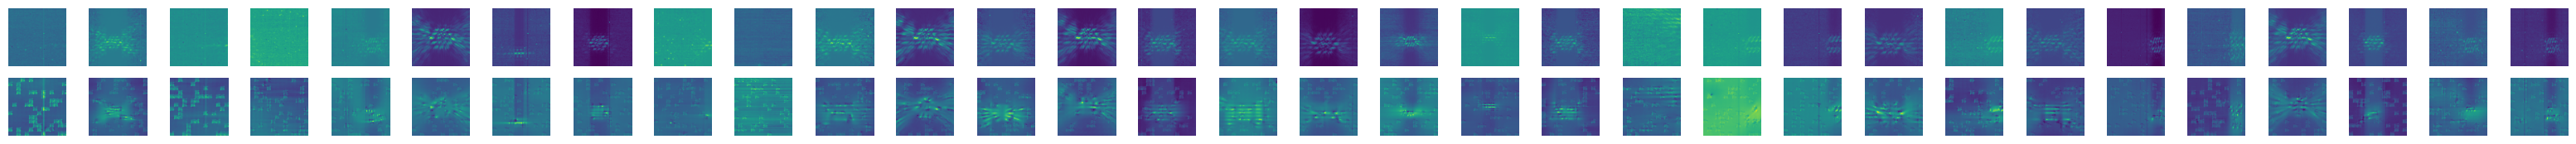

In [87]:
figure, axes = plt.subplots(2, images.shape[0])

figure.set_size_inches(40, 2)

for idx in range(images.shape[0]):
    axes[0][idx].imshow(test_data[idx][0].cpu())
    axes[1][idx].imshow(images[idx][0].detach().cpu())
    
    axes[0][idx].set_axis_off()
    axes[1][idx].set_axis_off()

In [16]:
latents = []

for idx, batch in enumerate(train_loader):
    batch = batch.to('cuda:2')
    batch = center_crop(batch)
    out_latent = mae.vit(test_data)
    latents.append(out_latent.last_hidden_state.view(batch_size, -1).detach().cpu())
latents = torch.cat(latents, dim=0)

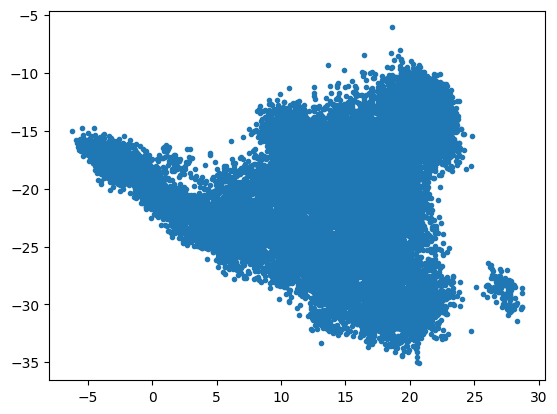

In [27]:
pca = torch.pca_lowrank(latents, 3)
pca_dist = torch.matmul(latents, pca[2]).cpu().numpy()

plt.scatter(pca_dist[:, 0], pca_dist[:, 1], marker='.')
plt.show()

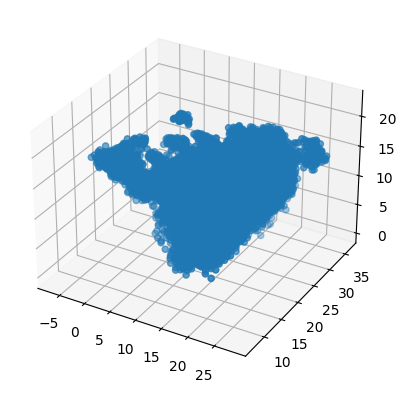

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(pca_dist[:, 0], pca_dist[:, 1], pca_dist[:, 2])
plt.show()